In [1]:
#For numerics
import numpy as np

#For loading and saving data
import pandas as pd

#For plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

#For TeX plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

#For colorblind plots
import seaborn
colors = list(seaborn.color_palette('colorblind').as_hex())

#
import itertools

#For setting root path and accessing files
import sys
import os
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root not in sys.path:
    sys.path.append(root)
os.chdir('..') 
import h5py

#for caching cross-section values
from functools import lru_cache

from lepton_nucleus_collisions.utils.process import process_run_card
from lepton_nucleus_collisions.process_crossx_data import crossx, dcrossx, distribution
from phys.constants import hc2_fbGeV2

In [2]:
experiments = ['E137', 'EIC_Gold', 'MuSIC', 'MuCol']
experiment_colors = [colors[1], colors[0], colors[2], colors[3]]
experiment_TeX = ['$\\textrm{E137}$','$\\textrm{EIC}$','$\\textrm{MuSIC}$','$\\textrm{MuBeD}$']

color_dict = dict(zip(experiments, experiment_colors))
TeX_dict = dict(zip(experiments, experiment_TeX))
run_cards = [f'{experiment}.txt' for experiment in experiments]

##  Plotting the cross-sections at each experiment:

To plot the cross-sections at each experiment, we first define a method to plot the cross-section for each final-state lepton given a final-state particle type. Then, we define a method which sets these lepton plots side-by-side for a (pseudo-)scalar and (axial-)vector. For a given $t_{\rm cutoff}$ (default is $(1~{\rm GeV})^2$) and method (default is exact), this figure allows comparison of the total production cross-section of the particle $\varphi$ at each experiment. 

In [3]:
def plot_crossx(experiment, params, PV_angle = None, ax = None, color = None, linestyle = 'solid', line_alpha = 1, fill_alpha = 1, units = 'pb', label = None):
    if not ax:
        ax = plt.gca()
    
    #experiments have a color by default
    if not color:
        color = color_dict[experiment]
        
    conversion = 1 # by default, GeV^{-2}
    if units == 'fb':
        conversion = hc2_fbGeV2
    if units == 'pb':
        conversion = hc2_fbGeV2/1000
    
    file_name = f'lepton_nucleus_collisions/data/{experiment}.h5'
    masses = np.array(process_run_card(f'{experiment}.txt', 'masses'))
    sig = crossx(experiment, params+(False,), units = units)
    sig_PV = sig + crossx(experiment, params + (True,), units = units)
    
    if PV_angle:
        plt.plot(masses, np.cos(PV_angle)**2 * sig + np.sin(PV_angle)**2 * sig_PV, color = color, alpha = line_alpha, label = label)
        
    else:
        ax.fill_between(masses,
                        sig,
                        sig_PV,
                        color = color,
                        alpha = fill_alpha)

        ax.plot(masses,
                sig,
                color = color,
                linestyle = linestyle,
                alpha = line_alpha,
                label = label)

        rel_diff = np.abs((sig_PV - sig)/sig)
        
        ax.plot(masses[rel_diff > 0.05],
                sig_PV[rel_diff > 0.05],
                color = color,
                linestyle = linestyle,
                alpha = line_alpha)

##  Plotting the cross-sections at each experiment:

To plot the cross-sections at each experiment, we first define a method to plot the cross-section for each final-state lepton given a final-state particle type. Then, we define a method which sets these lepton plots side-by-side for a (pseudo-)scalar and (axial-)vector. For a given $t_{\rm cutoff}$ (default is $(1~{\rm GeV})^2$) and method (default is exact), this figure allows comparison of the total production cross-section of the particle $\varphi$ at each experiment. 

In [4]:
def plot_leptons(experiment,
                 particle_type,
                 t_cut_off = 1.0,
                 method = 'exact',
                 ax = None,
                 color = None,
                 units = 'pb'):
    if not ax:
        ax = plt.gca()
    
    linestyle = ['solid', 'dashed', 'dotted']
    for idx, lepton in enumerate(['e', 'mu', 'tau']):
        plot_crossx(experiment,
                    (lepton, particle_type, t_cut_off, method),
                    ax = ax,
                    color = color,
                    linestyle = linestyle[idx],
                    fill_alpha = 0.2,
                    units = units)
        
def compare_particle_types(experiments,
                           ax1,
                           ax2,
                           t_cut_off = 1.0,
                           method = 'exact',
                           ylim = (1e0,1e14),
                           xlim = (1e-3,1e2),
                           units = 'pb'):
    
    ax1.set_title("$\\textrm{(Pseudo-)Scalar}$")
    
    params = ("scalar", t_cut_off, method)
    for experiment in experiments:
        plot_leptons(experiment, *params, ax = ax1)
        ax1.plot([1e16],
                 color = color_dict[experiment],
                 linestyle = 'solid',
                 label = TeX_dict[experiment])
        
    ax2.set_title("$\\textrm{(Axial-)Vector}$")
    
    params = ("vector", t_cut_off, method)        
    for experiment in experiments:
        plot_leptons(experiment, *params, ax = ax2)
        ax2.plot([1e16],
                 color = color_dict[experiment],
                 linestyle = 'solid',
                 label = TeX_dict[experiment])
    
    
    li = process_run_card(f'{experiment}.txt', 'li')
    li = '\\' + li if li != 'e' else li
    
    ax1.set_ylabel(f'$\\sigma({li}^- A_Z \\rightarrow \\ell^- A_Z \\varphi)/g_{{{li}\\ell}}^2~[{{\\rm {units}}}]$')
    ax1.tick_params(which = 'both', direction = 'in')
    ax2.tick_params(which = 'both', direction = 'in', labelleft = False)

    axes = [ax1, ax2]
    for ax in axes:
        ax.grid()
        
        ax.set_xlabel('$m_\\varphi~[\\textrm{GeV}]$')
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        if ylim:
            ax.set_ylim(*ylim)
        if xlim:
            ax.set_xlim(*xlim)
        ax.plot([1e16],
                color = 'grey',
                linestyle = 'solid',
                label = "$\\ell = e$")
        ax.plot([1e16],
                color = 'grey',
                linestyle = 'dashed',
                label = "$\\ell = \\mu$")
        ax.plot([1e16],
                color = 'grey',
                linestyle = 'dotted',
                label = "$\\ell = \\tau$")
        
        ax.legend(fancybox = False,
                  facecolor = 'white',
                  edgecolor = 'black',
                  framealpha = 1,
                  loc = 'upper right',
                  fontsize = 8,
                  borderpad = 0.6)
    return ax1, ax2

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_40074/4085905282.py:37: RuntimeWarning: invalid value encountered in divide
  rel_diff = np.abs((sig_PV - sig)/sig)


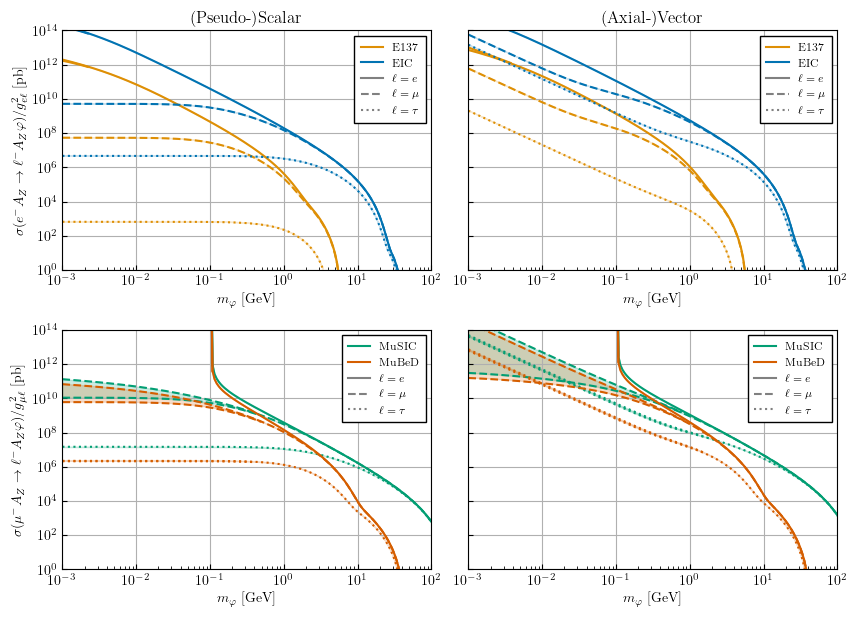

In [5]:
fig = plt.figure(figsize = (10, 7))
gs = GridSpec(2, 2, wspace = 0.1, hspace = 0.25)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax1, ax2 = compare_particle_types(['E137', 'EIC_Gold'], ax1, ax2)
ax3, ax4 = compare_particle_types(['MuSIC', 'MuCol'], ax3, ax4)
ax3.set_title(None)
ax4.set_title(None)

plt.savefig('figures/chapter4/production_crossx.pdf', format = 'pdf')

In [6]:
def relative_error(exact, approx):
    return np.abs(approx - exact)/np.abs(exact)

def plot_methods(experiment,
                 lepton,
                 particle_type,
                 t_cut_off,
                 color = None,
                 ax = None,
                 units = 'pb'):
    if not ax:
        ax == plt.gca() 

    if not color:
        color = color_dict[experiment]
        
        
    linestyle = ['solid', 'dashed', 'dotted']
    for idx, method in enumerate(['exact', 'WW', 'IWW']):
        plot_crossx(experiment,
                    (lepton, particle_type, t_cut_off, method),
                    ax = ax,
                    color = color,
                    linestyle = linestyle[idx],
                    fill_alpha = 0.2 if method=='exact' else 0.0,
                    units = units)
        
def plot_method_errors(experiment,
                       lepton,
                       particle_type,
                       t_cut_off = 1.0,
                       ax = None,
                       color = None):
    if not ax:
        ax = plt.gca()
    
    if not color:
        color = color_dict[experiment]
        
    params = (lepton, particle_type, t_cut_off)
    
    masses = process_run_card(f'{experiment}.txt', 'masses')
    
    sig_exact = crossx(experiment, params + ('exact',False))
    sig_exact_PV = sig_exact + crossx(experiment, params + ('exact', True))

    sig_WW = crossx(experiment, params + ('WW',False))
    sig_WW_PV = sig_WW + crossx(experiment, params + ('WW', True))
    
    sig_IWW = crossx(experiment, params + ('IWW',False))
    sig_IWW_PV = sig_IWW + crossx(experiment, params + ('IWW', True))
    
    ax.plot(masses, relative_error(sig_exact, sig_WW), color = color, linestyle = 'dashed')
    ax.plot(masses, relative_error(sig_exact_PV, sig_WW_PV), color = color, linestyle = 'dashed')
    
    ax.plot(masses, relative_error(sig_exact, sig_IWW), color = color, linestyle = 'dotted')
    ax.plot(masses, relative_error(sig_exact_PV, sig_IWW_PV), color = color, linestyle = 'dotted')
    
def compare_methods(experiments,
                    lepton,
                    gs,
                    t_cut_off = 1.0,
                    ylim = (1e0,1e14),
                    error_ylim = (1e-6, 1e0),
                    xlim = (1e-3,1e2),
                    units = 'pb'):
        
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[2], sharex = ax1)
    ax1.set_title("$\\textrm{(Pseudo-)Scalar}$")
    params = (lepton, 'scalar', t_cut_off)
    for experiment in experiments:
        plot_methods(experiment, *params, ax = ax1)
        plot_method_errors(experiment, *params, ax = ax2)
        ax1.plot([1e16],
                 color = color_dict[experiment],
                 linestyle = 'solid',
                 label = TeX_dict[experiment])
        
    ax3 = fig.add_subplot(gs[1])
    ax4 = fig.add_subplot(gs[3], sharex = ax3)
    ax3.set_title("$\\textrm{(Axial-)Vector}$")
    
    params = (lepton, 'vector', t_cut_off)        
    for experiment in experiments:
        plot_methods(experiment, *params, ax = ax3)
        plot_method_errors(experiment, *params, ax = ax4)
        ax3.plot([1e16],
                 color = color_dict[experiment],
                 linestyle = 'solid',
                 label = TeX_dict[experiment])
    
    ax1.tick_params(which = 'both', direction = 'in', labelbottom = False)
    ax2.tick_params(which = 'both', direction = 'in')
    ax3.tick_params(which = 'both', direction = 'in', labelbottom = False, labelleft = False)
    ax4.tick_params(which = 'both', direction = 'in', labelleft = False)
    
    li = process_run_card(f'{experiment}.txt', 'li')
    li = '\\' + li if li != 'e' else li
    lf = '\\' + lepton if lepton != 'e' else lepton
    
    ax1.set_ylabel(f'$\\sigma({li}^- A_Z \\rightarrow {lf}^- A_Z \\varphi)/g_{{{li}{lf}}}^2~[{{\\rm {units}}}]$')
    ax2.set_ylabel('$\\textrm{rel. error}$')

    axes = [ax1, ax2, ax3, ax4]
    for idx, ax in enumerate(axes):
        ax.grid()
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        if idx%2 == 0:
            if ylim:
                ax.set_ylim(*ylim)
                
            ax.plot([1e16],
                    color = 'grey',
                    linestyle = 'solid',
                    label = "$\\textrm{exact}$")
            ax.plot([1e16],
                    color = 'grey',
                    linestyle = 'dashed',
                    label = "$\\textrm{WW}$")
            ax.plot([1e16],
                    color = 'grey',
                    linestyle = 'dotted',
                    label = "$\\textrm{IWW}$")
        
            ax.legend(fancybox = False,
                      facecolor = 'white',
                      edgecolor = 'black',
                      framealpha = 1,
                      loc = 'upper right',
                      fontsize = 8,
                      borderpad = 0.6)
            
        if idx%2 == 1:
            if error_ylim:
                ax.set_ylim(*error_ylim)
            if xlim:
                ax.set_xlim(*xlim)
            ax.set_xlabel('$m_\\varphi~[\\textrm{GeV}]$')            
            
    return axes

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_40074/4085905282.py:37: RuntimeWarning: invalid value encountered in divide
  rel_diff = np.abs((sig_PV - sig)/sig)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_40074/2309948151.py:2: RuntimeWarning: invalid value encountered in divide
  return np.abs(approx - exact)/np.abs(exact)


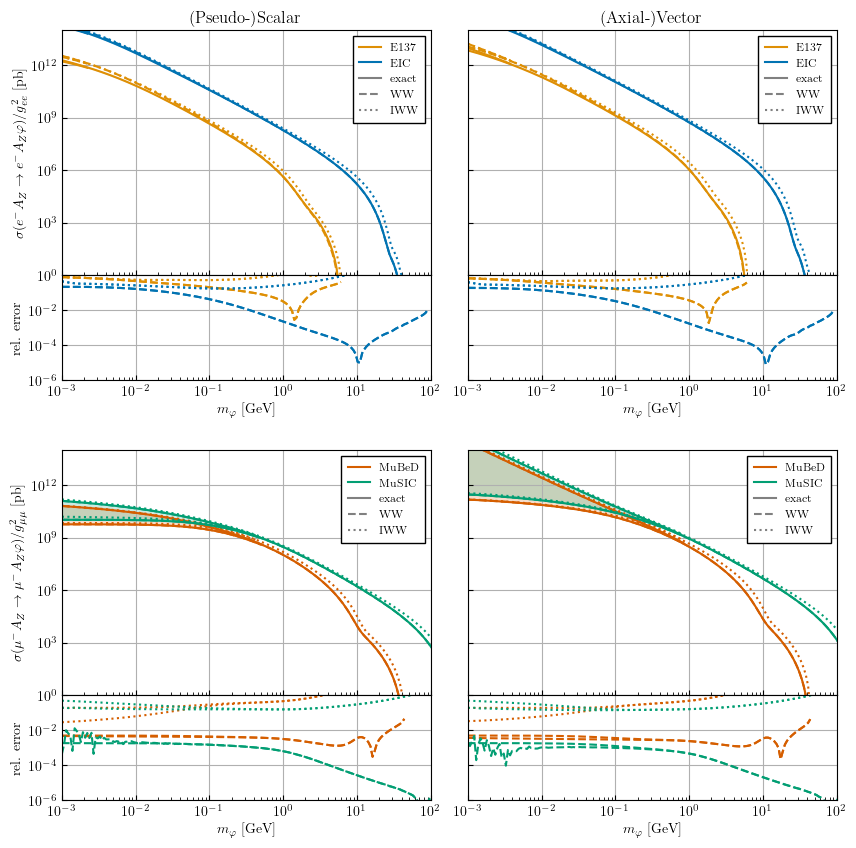

In [7]:
fig = plt.figure(figsize=(10, 10))

gs =  GridSpec(2, 1, height_ratios=[1, 1], hspace=0.2)

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[0], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax1, ax2, ax3, ax4 = compare_methods(['E137','EIC_Gold'], 'e', sub_gs)
ax1.set_yticks([1e3, 1e6, 1e9, 1e12])
ax3.set_yticks([1e3, 1e6, 1e9, 1e12])

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[1], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax5, ax6, ax7, ax8 = compare_methods(['MuCol','MuSIC'], 'mu', sub_gs)
ax5.set_yticks([1e3, 1e6, 1e9, 1e12])
ax7.set_yticks([1e3, 1e6, 1e9, 1e12])
ax5.set_title(None)
ax7.set_title(None)

plt.savefig('figures/chapter4/crossx_approximations_diagonal.pdf')

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_40074/4085905282.py:37: RuntimeWarning: invalid value encountered in divide
  rel_diff = np.abs((sig_PV - sig)/sig)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_40074/2309948151.py:2: RuntimeWarning: invalid value encountered in divide
  return np.abs(approx - exact)/np.abs(exact)


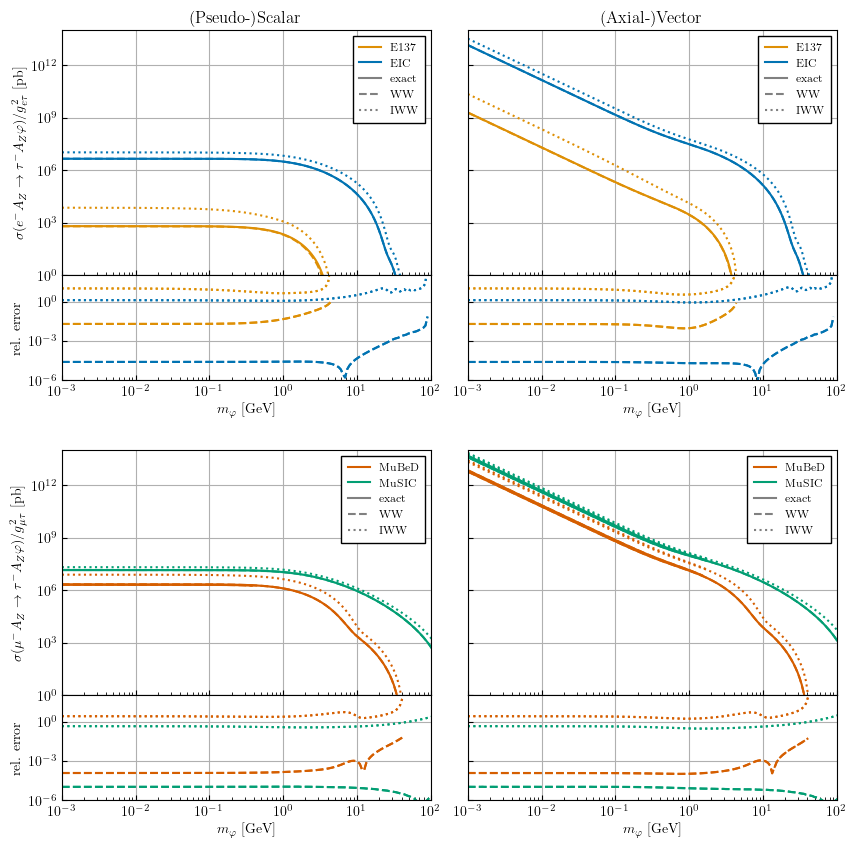

In [8]:
fig = plt.figure(figsize=(10, 10))

gs =  GridSpec(2, 1, height_ratios=[1, 1], hspace=0.2)

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[0], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax1, ax2, ax3, ax4 = compare_methods(['E137','EIC_Gold'], 'tau', sub_gs)

ax1.set_yticks([1e0, 1e3, 1e6, 1e9, 1e12])
ax3.set_yticks([1e0, 1e3, 1e6, 1e9, 1e12])

ax2.set_ylim(1e-6, 1e2)
ax4.set_ylim(1e-6, 1e2)

sub_gs = GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[1], height_ratios = [7/3, 1], hspace = 0, wspace = 0.1)
ax5, ax6, ax7, ax8 = compare_methods(['MuCol','MuSIC'], 'tau', sub_gs)

ax5.set_yticks([1e0, 1e3, 1e6, 1e9, 1e12])
ax7.set_yticks([1e0, 1e3, 1e6, 1e9, 1e12])

ax6.set_ylim(1e-6, 1e2)
ax8.set_ylim(1e-6, 1e2)

ax5.set_title(None)
ax7.set_title(None)

plt.savefig('figures/chapter4/crossx_approximations_tau.pdf')

In [9]:
def smooth(y, x, xscale = 'lin', tol = 500):
    if xscale == 'lin':
        x_ = x
        y_ = y
    elif xscale == 'log':
        x_ = np.log10(x)
        y_ = np.log10(y)
        
    dy_dx = np.gradient(y_, x_)
    d2y_dx2 = np.gradient(dy_dx, x_)
        
    #pick max, *then* average
    y_smooth = np.array([np.nanmax(y[max(i-20, 0):min(i+1, len(y))]) for i in range(len(y))])        
    y_smooth = np.where(np.abs(d2y_dx2) > tol, y_smooth, y)
    y_smooth = np.array([np.nanmean(y_smooth[max(i-5, 0):min(i+5, len(y))]) for i in range(len(y))])

    return y_smooth
        

# If xs and ys are arrays of independent and corresponding dependent variables, this 
# effectively computes the envelope of every y(x). To do so, it first finds the pair
# (x0, y(x0)) which maximizes each y. Then, it appends the curves at the start and
# end.
def envelope(xs, ys, xscale = 'lin', smooth_y = False):
    
    x_min = np.min(xs[ys > 0])
    x_max = np.max(xs[ys > 0])
    
    if xscale == 'lin':
        x_env = np.linspace(x_min, x_max, 1000)
    elif xscale == 'log':
        x_env = np.geomspace(x_min, x_max, 1000)
    
    x_nearest = []
    y_nearest = []
    for idx, (x, y) in enumerate(zip(xs, ys)):
        argmins = [np.argmin(np.abs(x-x_e)) for x_e in x_env]
        x_nearest.append(np.array([x[argmin] for argmin in argmins]))
        y_nearest.append(np.array([y[argmin] for argmin in argmins]))
    
    y_env = np.nanmax(y_nearest, axis = 0)
    if smooth_y:
        y_env = smooth(y_env, x_env, xscale = xscale, tol = 10)
    
    _, args = np.unique(y_env, return_index = True)
    y_env = y_env[sorted(args)]
    x_env = x_env[sorted(args)]
    
    return x_env, y_env
    
def eta_envelope(experiment, params, idx_min = 0, idx_max = -1):
    masses = process_run_card(f'{experiment}.txt', 'masses')
    #etas, dcrossx_deta = np.array([dcrossx(experiment, params + (m,), which = 'Y') for m in masses]).transpose((1, 0, 2))
    #cx = crossx(experiment, params, units = 'GeV')[idx_min:idx_max].reshape(-1, 1)

    etas, dist = np.array([distribution(experiment, params + (m,), which = 'Y') for m in masses[idx_min:idx_max]]).transpose(1, 0, 2)

    #return envelope(etas[idx_min:idx_max], dcrossx_deta[idx_min:idx_max]/cx, xscale = 'lin')
    return envelope(etas, dist, xscale = 'lin')

def gamma_envelope(experiment, params, idx_min = 0, idx_max = -1):
    masses = process_run_card(f'{experiment}.txt', 'masses')
    #gams, dcrossx_dgam = np.array([dcrossx(experiment, params + (m,), which = 'X') for m in masses]).transpose((1, 0, 2))
    #cx = crossx(experiment, params, units = 'GeV')[idx_min:idx_max].reshape(-1, 1)

    gams, dist = np.array([distribution(experiment, params + (m,), which = 'X') for m in masses[idx_min:idx_max]]).transpose(1, 0, 2)
    
    #return envelope(gams[idx_min:idx_max], dcrossx_dgam[idx_min:idx_max]/cx, xscale = 'log', smooth_y = True)
    return envelope(gams, dist, xscale = 'log', smooth_y = True)

In [87]:
def plot_distribution(experiment, params, idcs, plot_envelope = True, which = 'eta', color = None, ax = None):
    masses = process_run_card(f'{experiment}.txt', 'masses')
    mass_idcs = np.array([masses[idx] for idx in idcs])
    if which == 'eta':
        xs, ys = np.array([distribution(experiment, params + (m,), which = 'Y') for m in mass_idcs]).transpose((1, 0, 2))
        
        if plot_envelope:
            x_env, y_env = eta_envelope(experiment, params, idcs[0], idcs[-1]+1)
    elif which == 'gamma':
        xs, ys = np.array([distribution(experiment, params + (m,), which = 'X') for m in mass_idcs]).transpose((1, 0, 2))
        
        if plot_envelope:
            x_env, y_env = gamma_envelope(experiment, params, idcs[0], idcs[-1]+1)            
    
    if not ax:
        ax = plt.gca()

    if not color:
        color = color_dict[experiment]
    
    if plot_envelope:
        ax.fill_between(x_env, y_env, color = color, alpha = 0.1)
        ax.plot(x_env, y_env, color = color, linestyle = 'dashed')
        
    for x, y in zip(xs, ys):
        ax.plot(x, y, color = color)
        
    xmin = x_env[y_env > 0].min()
    xmax = x_env[y_env > 0].max()    
    
    plt.xlim(xmin, xmax)
    
    ax.tick_params(which = 'both', direction = 'in')
    
    return ax
    
def plot_distribution_average(experiment, params, which = 'eta', final_state_particle = 'phi', color = None, ax = None):
    masses = np.array(process_run_card(f'{experiment}.txt', 'masses'))
    if which == 'eta':
        xs, ys = np.array([distribution(experiment, params + (m,), which = 'Y', final_state_particle = final_state_particle) for m in masses]).transpose((1, 0, 2))

    elif which == 'gamma':
        xs, ys = np.array([distribution(experiment, params + (m,), which = 'X', final_state_particle = final_state_particle) for m in masses]).transpose((1, 0, 2))

    y_tot = np.trapz(ys, x = xs).reshape(-1, 1)
    y_ints = np.array([np.trapz(ys[:, :idx]/y_tot, x = xs[:, :idx]) for idx in range(len(xs[0]))]).T
    x_50 = np.array([np.interp(0.5, y_ints[idx], xs[idx]) for idx in range(len(masses))])
    x_25 = np.array([np.interp(0.25, y_ints[idx], xs[idx]) for idx in range(len(masses))])
    x_75 = np.array([np.interp(0.75, y_ints[idx], xs[idx]) for idx in range(len(masses))])
    #x_75 = np.where(x_75 == 30, np.nan, x_75)

    #
    #x_avg = np.trapz(xs*ys, x = xs)

    endpt = np.min(np.where(np.isnan(x_50) + (x_50 == x_50[-1]))) - 1

    #endpt = np.min(np.where(np.isnan(x_avg) + (x_avg == x_avg[-1]))) - 1

    #smooth everything before the endpt...
    #x_avg = np.where(masses < masses[endpt - 5], smooth(x_avg, masses, xscale = 'log', tol = 500), x_avg)
    
    #x_std = np.sqrt(np.trapz((xs - x_avg.reshape(-1, 1))**2 * ys, x = xs))
    
    
    if not ax:
        ax = plt.gca()
        
    if not color:
        color = color_dict[experiment]
        
    #ax.fill_between(masses, x_avg - x_std, x_avg + x_std, color = color, alpha = 0.1)
    #ax.plot(masses, x_avg-x_std, color = color)
    #ax.plot(masses, x_avg+x_std, color = color)
    #ax.plot(masses, x_avg, color = color, linestyle = 'dotted', alpha = 0.5)

    ax.fill_between(masses, x_25, x_75, color = color, alpha = 0.1)
    ax.plot(masses, x_25, color = color)
    ax.plot(masses, x_75, color = color)
    ax.plot(masses, x_50, color = color, linestyle = 'dotted', alpha = 0.5)
    
    
    #connect the edges
    xmin = x_25[endpt]
    xmax = x_75[endpt]
    ax.plot([masses[endpt], masses[endpt]], [xmin, xmax], color = color)
    
    return ax

E137 done
EIC done
MuBeD done
MuSIC done


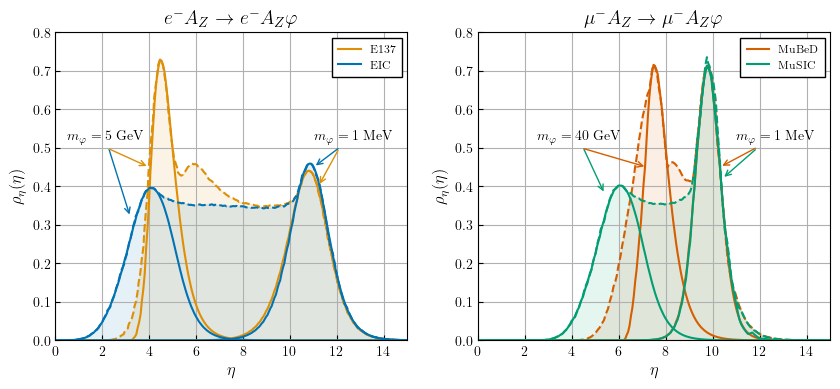

In [75]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

plot_distribution('E137', ('e', 'scalar', 1.0, 'exact', False), [0, 129],
                  ax = ax1, which = 'eta')
print('E137 done')
plot_distribution('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False), [0, 129],
                  ax = ax1, which = 'eta')
print('EIC done')

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)

ax1.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (11, 0.52),
             xy = (11, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (12.1, 0.5),
             xy = (11.2, 0.4),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))

ax1.annotate('$m_\\varphi = 5~{\\rm GeV}$',
             xytext = (0.5, 0.52),
             xy = (3.2, 0.32),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (2.2, 0.5),
             xy = (4, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))

ax1.set_title('$e^- A_Z \\rightarrow e^- A_Z \\varphi$', fontsize = 14)
ax1.set_xlabel('$\\eta$', fontsize = 12)
ax1.set_ylabel('$\\rho_\\eta(\\eta)$', fontsize = 12)

ax1.set_xlim(0, 15)
ax1.set_ylim(0, 0.8)
ax1.grid()

ax2 = fig.add_subplot(gs[1])

plot_distribution('MuCol', ('mu', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'eta')
print('MuBeD done')
plot_distribution('MuSIC', ('mu', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'eta')
print('MuSIC done')


ax2.plot([100], color = colors[3], label = '${\\rm MuBeD}$')
ax2.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax2.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)

ax2.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (11, 0.52),
             xy = (10.3, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))
ax2.annotate('',
             xytext = (11.9, 0.5),
             xy = (10.4, 0.42),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))


ax2.annotate('$m_\\varphi = 40~{\\rm GeV}$',
             xytext = (2.5, 0.52),
             xy = (5.4, 0.38),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))
ax2.annotate('',
             xytext = (4.4, 0.5),
             xy = (7.2, 0.45),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))

ax2.set_title('$\\mu^- A_Z \\rightarrow \\mu^- A_Z \\varphi$', fontsize = 14)
ax2.set_xlabel('$\\eta$', fontsize = 12)
ax2.set_ylabel('$\\rho_\\eta(\\eta)$', fontsize = 12)


ax2.set_xlim(0, 15)
ax2.set_ylim(0, 0.8)
ax2.grid()

plt.savefig('figures/chapter4/eta_distributions_diagonal.pdf', format = 'pdf')

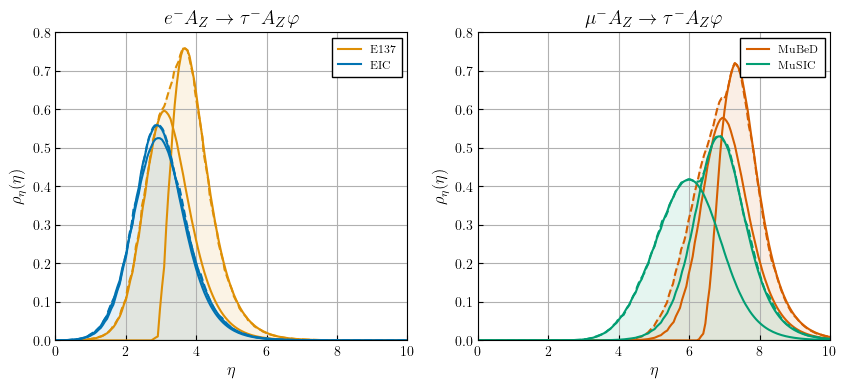

In [76]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

plot_distribution('E137', ('tau', 'scalar', 1.0, 'exact', False), [0, 125],
                  ax = ax1, which = 'eta')
plot_distribution('EIC_Gold', ('tau', 'scalar', 1.0, 'exact', False), [0, 125],
                  ax = ax1, which = 'eta')

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)


ax1.set_title('$e^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax1.set_xlabel('$\\eta$', fontsize = 12)
ax1.set_ylabel('$\\rho_\\eta(\\eta)$', fontsize = 12)

ax1.set_xlim(0, 10)
ax1.set_ylim(0, 0.8)
ax1.grid()

ax2 = fig.add_subplot(gs[1])

plot_distribution('MuCol', ('tau', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'eta')
plot_distribution('MuSIC', ('tau', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'eta')


ax2.plot([100], color = colors[3], label = '${\\rm MuBeD}$')
ax2.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax2.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)

ax2.set_title('$\\mu^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax2.set_xlabel('$\\eta$', fontsize = 12)
ax2.set_ylabel('$\\rho_\\eta(\\eta)$', fontsize = 12)


ax2.set_xlim(0, 10)
ax2.set_ylim(0, 0.8)
ax2.grid()

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_40074/1273969183.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  y_tot = np.trapz(ys, x = xs).reshape(-1, 1)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_40074/1273969183.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  y_ints = np.array([np.trapz(ys[:, :idx]/y_tot, x = xs[:, :idx]) for idx in range(len(xs[0]))]).T


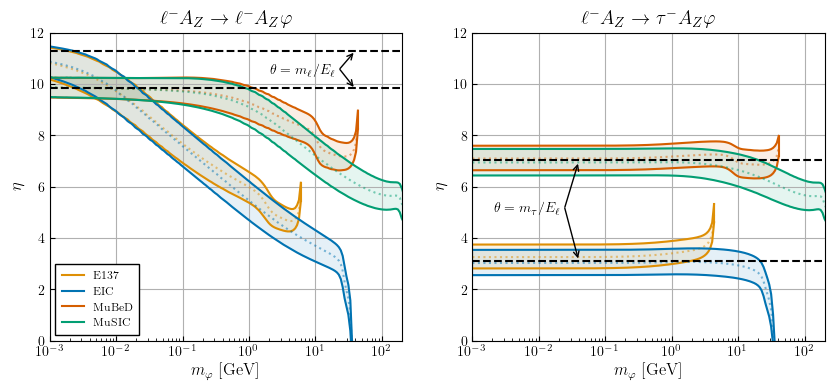

In [88]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

plot_distribution_average('E137', ('e', 'scalar', 1.0, 'exact', False), which = 'eta')
plot_distribution_average('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False), which = 'eta')
plot_distribution_average('MuCol', ('mu', 'scalar', 1.0, 'exact', False), which = 'eta')
plot_distribution_average('MuSIC', ('mu', 'scalar', 1.0, 'exact', False), which = 'eta')

ax1.text(2.1, 10.4, '$\\theta = m_\\ell / E_\\ell$', color = 'black')
ax1.annotate('', (40, 9.8), (22, 10.65),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax1.annotate('', (40, 11.3), (22, 10.52),
             arrowprops = dict(arrowstyle = '->', color = 'black'))

ax1.axhline(-np.log(np.tan(5.11e-4/(2*20))), color = 'black', linestyle = 'dashed')
ax1.axhline(-np.log(np.tan(0.106/(2*1000))), color = 'black', linestyle = 'dashed')

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.plot([100], color = colors[3], label = '${\\rm MuBeD}$')
ax1.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'lower left',
           fontsize = 8,
           borderpad = 0.6)

ax1.set_title('$\\ell^- A_Z \\rightarrow \\ell^- A_Z \\varphi$', fontsize = 14)
ax1.set_ylabel('$\\eta$', fontsize = 12)
ax1.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax1.tick_params(which = 'both', direction = 'in')
ax1.grid()
ax1.set_xscale('log')
ax1.set_xlim(1e-3, 2e2)
ax1.set_ylim(0, 12)

ax2 = fig.add_subplot(gs[1])

plot_distribution_average('E137', ('tau', 'scalar', 1.0, 'exact', False), which = 'eta')
plot_distribution_average('EIC_Gold', ('tau', 'scalar', 1.0, 'exact', False), which = 'eta')
plot_distribution_average('MuCol', ('tau', 'scalar', 1.0, 'exact', False), which = 'eta')
plot_distribution_average('MuSIC', ('tau', 'scalar', 1.0, 'exact', False), which = 'eta')


ax2.text(2.1e-3, 5, '$\\theta = m_\\tau / E_\\ell$', color = 'black')
ax2.annotate('', (4e-2, 3.1), (2.4e-2, 5.27),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax2.annotate('', (4e-2, 7), (2.4e-2, 5.10),
             arrowprops = dict(arrowstyle = '->', color = 'black'))


ax2.axhline(-np.log(np.tan(1.77/(2*20))), color = 'black', linestyle = 'dashed')
ax2.axhline(-np.log(np.tan(1.77/(2*1000))), color = 'black', linestyle = 'dashed')

ax2.set_title('$\\ell^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax2.set_ylabel('$\\eta$', fontsize = 12)
ax2.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax2.tick_params(which = 'both', direction = 'in')
ax2.grid()
ax2.set_xscale('log')

ax2.set_xlim(1e-3, 2e2)
ax2.set_ylim(0, 12)

plt.savefig('figures/chapter4/average_eta.pdf', format = 'pdf')

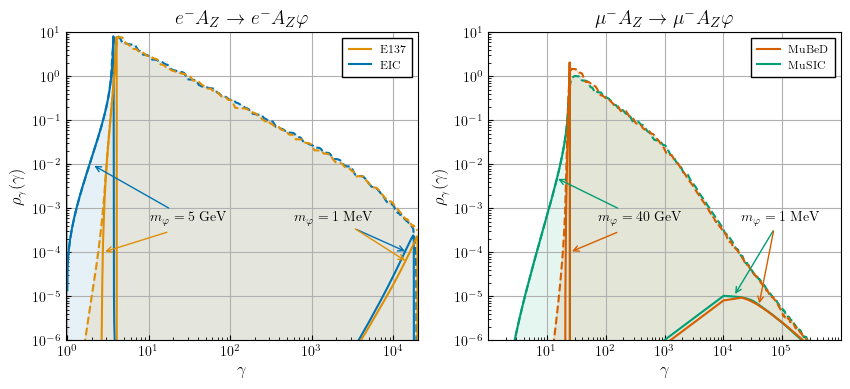

In [31]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

plot_distribution('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False), [0, 129],
                  ax = ax1, which = 'gamma')
plot_distribution('E137', ('e', 'scalar', 1.0, 'exact', False), [0, 129],
                  ax = ax1, which = 'gamma')

ax1.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (600, 5e-4),
             xy = (1.5e4, 1e-4),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (3.2e3, 3.7e-4),
             xy = (1.5e4, 6e-5),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))

ax1.annotate('$m_\\varphi = 5~{\\rm GeV}$',
             xytext = (10.2, 5e-4),
             xy = (2, 1e-2),
             arrowprops = dict(arrowstyle = '->', color = colors[0]))
ax1.annotate('',
             xytext = (18, 3e-4),
             xy = (2.7, 1e-4),
             arrowprops = dict(arrowstyle = '->', color = colors[1]))


ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)


ax1.set_title('$e^- A_Z \\rightarrow e^- A_Z \\varphi$', fontsize = 14)
ax1.set_xlabel('$\\gamma$', fontsize = 12)
ax1.set_ylabel('$\\rho_\\gamma(\\gamma)$', fontsize = 12)

ax1.grid()
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(0.95, 2e4)
ax1.set_ylim(1e-6, 1e1)

ax2 = fig.add_subplot(gs[1])

plot_distribution('MuSIC', ('mu', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'gamma')
plot_distribution('MuCol', ('mu', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'gamma')

ax2.annotate('$m_\\varphi = 1~{\\rm MeV}$',
             xytext = (2e4, 5e-4),
             xy = (1.5e4, 1e-5),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))
ax2.annotate('',
             xytext = (7.3e4, 3.5e-4),
             xy = (4e4, 6e-6),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))

ax2.annotate('$m_\\varphi = 40~{\\rm GeV}$',
             xytext = (73, 5e-4),
             xy = (14, 5e-3),
             arrowprops = dict(arrowstyle = '->', color = colors[2]))
ax2.annotate('',
             xytext = (170, 3e-4),
             xy = (24, 1e-4),
             arrowprops = dict(arrowstyle = '->', color = colors[3]))


ax2.plot([100], color = colors[3], label = '${\\rm MuBeD}$')
ax2.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax2.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)


ax2.set_title('$\\mu^- A_Z \\rightarrow \\mu^- A_Z \\varphi$', fontsize = 14)
ax2.set_xlabel('$\\gamma$', fontsize = 12)
ax2.set_ylabel('$\\rho_\\gamma(\\gamma)$', fontsize = 12)

ax2.grid()
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(1e-6, 1e1)

plt.savefig('figures/chapter4/gamma_distributions_diagonal.pdf', format = 'pdf')

(1e-07, 10.0)

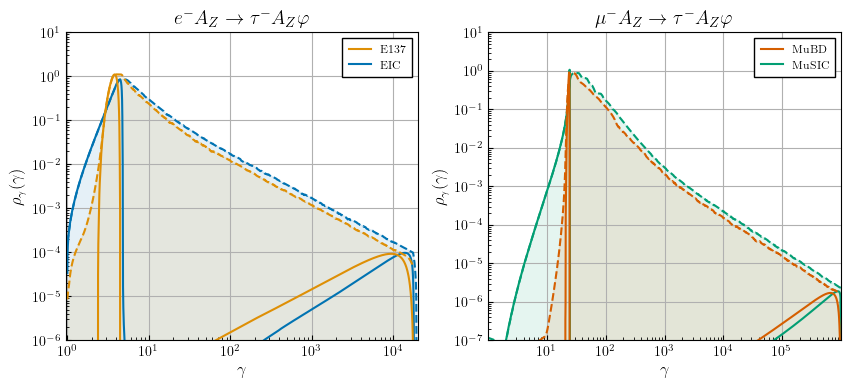

In [15]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

plot_distribution('EIC_Gold', ('tau', 'scalar', 1.0, 'exact', False), [0, 125],
                  ax = ax1, which = 'gamma')
plot_distribution('E137', ('tau', 'scalar', 1.0, 'exact', False), [0, 125],
                  ax = ax1, which = 'gamma')

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)


ax1.set_title('$e^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax1.set_xlabel('$\\gamma$', fontsize = 12)
ax1.set_ylabel('$\\rho_\\gamma(\\gamma)$', fontsize = 12)

ax1.grid()
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(0.95, 2e4)
ax1.set_ylim(1e-6, 1e1)

ax2 = fig.add_subplot(gs[1])

plot_distribution('MuSIC', ('tau', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'gamma')
plot_distribution('MuCol', ('tau', 'scalar', 1.0, 'exact', False), [0, 161],
                  ax = ax2, which = 'gamma')


ax2.plot([100], color = colors[3], label = '${\\rm MuBeD}$')
ax2.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax2.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'upper right',
           fontsize = 8,
           borderpad = 0.6)


ax2.set_title('$\\mu^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax2.set_xlabel('$\\gamma$', fontsize = 12)
ax2.set_ylabel('$\\rho_\\gamma(\\gamma)$', fontsize = 12)

ax2.grid()
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(1e-7, 1e1)

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_40074/1273969183.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  y_tot = np.trapz(ys, x = xs).reshape(-1, 1)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_40074/1273969183.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  y_ints = np.array([np.trapz(ys[:, :idx]/y_tot, x = xs[:, :idx]) for idx in range(len(xs[0]))]).T


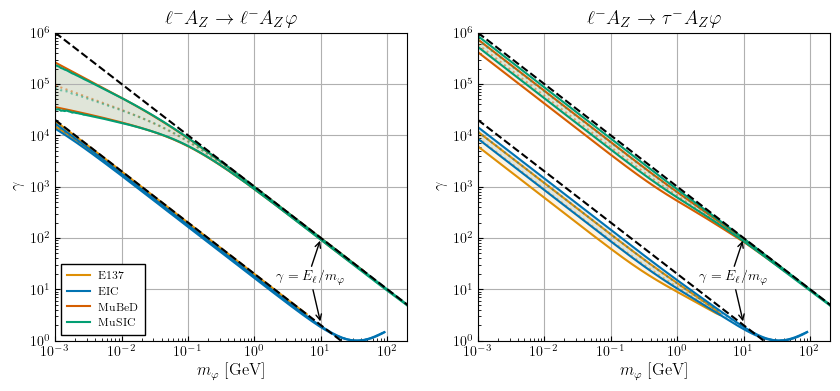

In [93]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

plot_distribution_average('E137', ('e', 'scalar', 1.0, 'exact', False), which = 'gamma')
plot_distribution_average('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False), which = 'gamma')
plot_distribution_average('MuCol', ('mu', 'scalar', 1.0, 'exact', False), which = 'gamma')
plot_distribution_average('MuSIC', ('mu', 'scalar', 1.0, 'exact', False), which = 'gamma')

#ax1.text(2.1, 20, '$\\gamma = E_\\ell / m_\\ell$', color = 'black')
ax1.annotate('$\\gamma = E_\\ell / m_\\varphi$', (10, 2.1), (2.1, 15),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax1.annotate('', (10, 100), (7, 25),
             arrowprops = dict(arrowstyle = '->', color = 'black'))

masses = np.array(process_run_card('E137.txt', 'masses'))

ax1.plot(masses, 20/masses, color = 'black', linestyle = 'dashed')
ax1.plot(masses, 1000/masses, color = 'black', linestyle = 'dashed')

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.plot([100], color = colors[3], label = '${\\rm MuBeD}$')
ax1.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'lower left',
           fontsize = 8,
           borderpad = 0.6)

ax1.set_title('$\\ell^- A_Z \\rightarrow \\ell^- A_Z \\varphi$', fontsize = 14)
ax1.set_ylabel('$\\gamma$', fontsize = 12)
ax1.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax1.tick_params(which = 'both', direction = 'in')
ax1.grid()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-3, 2e2)
ax1.set_ylim(1e0, 1e6)

ax2 = fig.add_subplot(gs[1])

plot_distribution_average('E137', ('tau', 'scalar', 1.0, 'exact', False), which = 'gamma')
plot_distribution_average('EIC_Gold', ('tau', 'scalar', 1.0, 'exact', False), which = 'gamma')
plot_distribution_average('MuCol', ('tau', 'scalar', 1.0, 'exact', False), which = 'gamma')
plot_distribution_average('MuSIC', ('tau', 'scalar', 1.0, 'exact', False), which = 'gamma')


ax2.annotate('$\\gamma = E_\\ell / m_\\varphi$', (10, 2.1), (2.1, 15),
             arrowprops = dict(arrowstyle = '->', color = 'black'))
ax2.annotate('', (10, 100), (7, 25),
             arrowprops = dict(arrowstyle = '->', color = 'black'))

ax2.plot(masses, 20/masses, color = 'black', linestyle = 'dashed')
ax2.plot(masses, 1000/masses, color = 'black', linestyle = 'dashed')

ax2.set_title('$\\ell^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax2.set_ylabel('$\\gamma$', fontsize = 12)
ax2.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax2.tick_params(which = 'both', direction = 'in')
ax2.grid()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1e-3, 2e2)
ax2.set_ylim(1e0, 1e6)

plt.savefig('figures/chapter4/average_gamma.pdf', format = 'pdf')

...

0.014


/Volumes/T7/Research/Thesis/lepton_nucleus_collisions/process_crossx_data.py:248: RuntimeWarning: invalid value encountered in arcsin
  TH_phi = np.where(kinematic_constraint, np.arcsin(p_f * np.sin(TH_f)/k_phi), 0)
/Volumes/T7/Research/Thesis/lepton_nucleus_collisions/process_crossx_data.py:242: RuntimeWarning: invalid value encountered in sqrt
  k_phi = np.sqrt(E_phi**2 - m_phi**2)


0.731


/Volumes/T7/Research/Thesis/lepton_nucleus_collisions/process_crossx_data.py:257: RuntimeWarning: invalid value encountered in sqrt
  J = np.sqrt(J/(E_phi**2 - m_phi**2))/np.cos(TH_phi) * kinematic_constraint


(-10.0, 15.0)

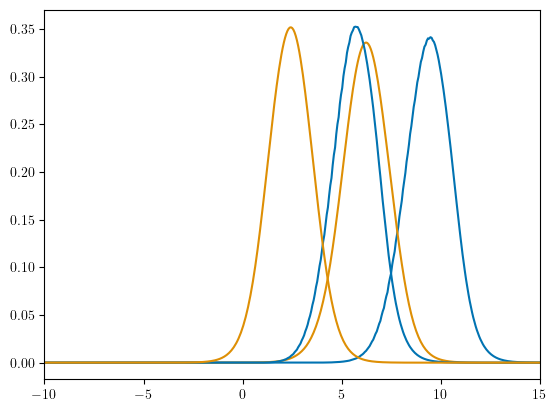

In [17]:
masses = process_run_card('EIC_Gold.txt', 'masses')

idx = 40
print(masses[idx])

ETA, DSIG_DETA = dcrossx('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False, masses[idx]), frame = 'lab', which = 'Y', Y_var = 'ETA')
SIG = crossx('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False), frame = 'lab', units = 'GeV')[idx]
RHO = DSIG_DETA/SIG

plt.plot(ETA, RHO, color = colors[0])

ETA, DSIG_DETA = dcrossx('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False, masses[idx]), frame = 'lab', which = 'Y', Y_var = 'ETA', final_state_particle='lepton')
SIG = crossx('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False), frame = 'lab', units = 'GeV')[idx]
RHO = DSIG_DETA/SIG

plt.plot(ETA, RHO, color = colors[1])

plt.xlim(-10, 10)

idx = 100
print(masses[idx])

ETA, DSIG_DETA = dcrossx('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False, masses[idx]), frame = 'lab', which = 'Y', Y_var = 'ETA')
SIG = crossx('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False), frame = 'lab', units = 'GeV')[idx]
RHO = DSIG_DETA/SIG

plt.plot(ETA, RHO, color = colors[0])

ETA, DSIG_DETA = dcrossx('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False, masses[idx]), frame = 'lab', which = 'Y', Y_var = 'ETA', final_state_particle='lepton')
SIG = crossx('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False), frame = 'lab', units = 'GeV')[idx]
RHO = DSIG_DETA/SIG

plt.plot(ETA, RHO, color = colors[1])

plt.xlim(-10, 15)


2.73
10.2


(0.001, 10.0)

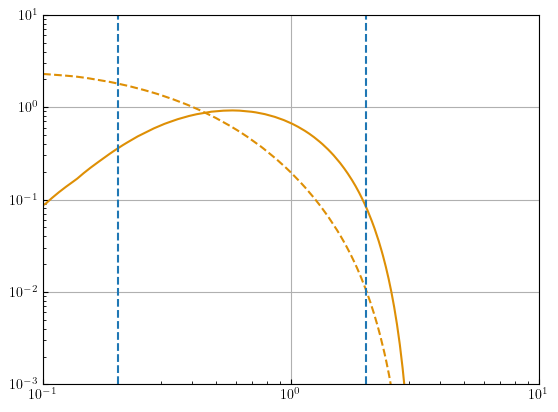

In [18]:
tau_lifetime = 2e-13 #seconds
tau_decay_width = 3e10*tau_lifetime #c \tau

masses = process_run_card('MuCol.txt', 'masses')
experiment = 'MuCol'
idx = 120
print(masses[idx])

GAM, DSIG_DGAM = dcrossx(experiment, ('tau', 'scalar', 1.0, 'exact', False, masses[idx]), frame = 'lab', which = 'X', final_state_particle='lepton')
SIG = crossx(experiment, ('tau', 'scalar', 1.0, 'exact', False), frame = 'lab', units = 'GeV')[idx]
RHO = DSIG_DGAM/SIG
plt.plot(GAM*tau_decay_width, RHO/tau_decay_width, color = colors[1])

idx = 140
print(masses[idx])

GAM, DSIG_DGAM = dcrossx(experiment, ('tau', 'scalar', 1.0, 'exact', False, masses[idx]), frame = 'lab', which = 'X', final_state_particle='lepton')
SIG = crossx(experiment, ('tau', 'scalar', 1.0, 'exact', False), frame = 'lab', units = 'GeV')[idx]
RHO = DSIG_DGAM/SIG
plt.plot(GAM*tau_decay_width, RHO/tau_decay_width, color = colors[1], linestyle = 'dashed')

plt.xscale('log')
plt.yscale('log')

plt.gca().grid()
plt.tick_params(which = 'both', direction = 'in')

plt.axvline(2e-1, linestyle = 'dashed')
plt.axvline(2e0, linestyle = 'dashed')

plt.xlim(1e-1, 1e1)
plt.ylim(1e-3, 1e1)

2.73
10.2


(0.001, 100.0)

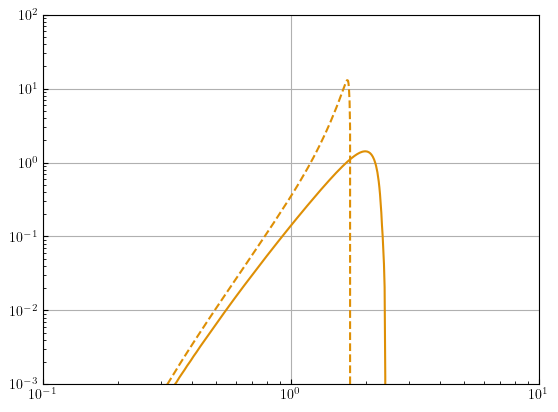

In [19]:
tau_lifetime = 2e-13 #seconds
tau_decay_width = 3e10*tau_lifetime #c \tau

masses = process_run_card('MuCol.txt', 'masses')
experiment = 'MuCol'
idx = 120
print(masses[idx])

GAM, DSIG_DGAM = dcrossx(experiment, ('tau', 'scalar', 1.0, 'exact', False, masses[idx]), frame = 'ion', which = 'X')
SIG = crossx(experiment, ('tau', 'scalar', 1.0, 'exact', False), frame = 'ion', units = 'GeV')[idx]
RHO = DSIG_DGAM/SIG

Et = (masses[idx]**2 + 1.777**2)/(2*masses[idx])
GAM = GAM * Et/1.777

plt.plot(GAM*tau_decay_width, RHO/tau_decay_width, color = colors[1])

idx = 140
print(masses[idx])

GAM, DSIG_DGAM = dcrossx(experiment, ('tau', 'scalar', 1.0, 'exact', False, masses[idx]), frame = 'ion', which = 'X')
SIG = crossx(experiment, ('tau', 'scalar', 1.0, 'exact', False), frame = 'ion', units = 'GeV')[idx]
RHO = DSIG_DGAM/SIG

Et = (masses[idx]**2 + 1.777**2)/(2*masses[idx])
GAM = GAM * Et/1.777

plt.plot(GAM*tau_decay_width, RHO/tau_decay_width, color = colors[1], linestyle = 'dashed')

plt.xscale('log')
plt.yscale('log')

plt.gca().grid()
plt.tick_params(which = 'both', direction = 'in')
plt.xlim(1e-1, 1e1)
plt.ylim(1e-3, 1e2)

2.73
10.2


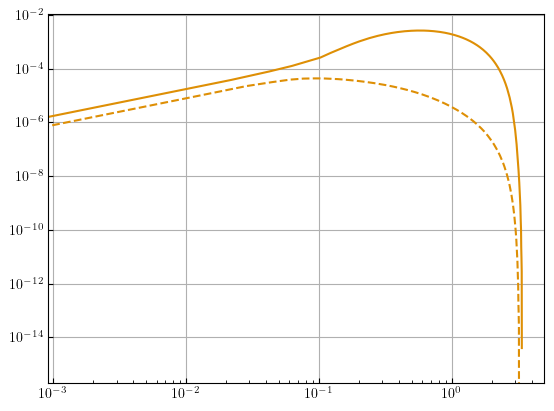

In [20]:
tau_lifetime = 2e-13 #seconds
tau_decay_width = 3e10*tau_lifetime #c \tau

Ei, masses = process_run_card('MuCol.txt', ['Ei', 'masses'])
experiment = 'MuCol'
idx = 120
print(masses[idx])

X, DSIG_DX = dcrossx(experiment, ('tau', 'scalar', 1.0, 'exact', False, masses[idx]), frame = 'ion', which = 'X', X_var = 'X')
SIG = crossx(experiment, ('tau', 'scalar', 1.0, 'exact', False), frame = 'ion', units = 'GeV')[idx]
RHO = DSIG_DX/SIG

#Et = (masses[idx]**2 + 1.777**2)/(2*masses[idx])
#GAM = GAM * Et/1.777

GAM = (1-X) * Ei/1.777

plt.plot(GAM*tau_decay_width, DSIG_DX, color = colors[1])

idx = 140
print(masses[idx])

X, DSIG_DX = dcrossx(experiment, ('tau', 'scalar', 1.0, 'exact', False, masses[idx]), frame = 'ion', which = 'X', X_var = 'X')
SIG = crossx(experiment, ('tau', 'scalar', 1.0, 'exact', False), frame = 'ion', units = 'GeV')[idx]
RHO = DSIG_DX/SIG

GAM = (1-X) * Ei/1.777

plt.plot(GAM*tau_decay_width, DSIG_DX, color = colors[1], linestyle = 'dashed')

plt.xscale('log')
plt.yscale('log')

plt.gca().grid()
plt.tick_params(which = 'both', direction = 'in')
#plt.xlim(1e-1, 1e1)
#plt.ylim(1e-3, 1e2)

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_40074/1273969183.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  y_tot = np.trapz(ys, x = xs).reshape(-1, 1)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_40074/1273969183.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  y_ints = np.array([np.trapz(ys[:, :idx]/y_tot, x = xs[:, :idx]) for idx in range(len(xs[0]))]).T


(-2.0, 12.0)

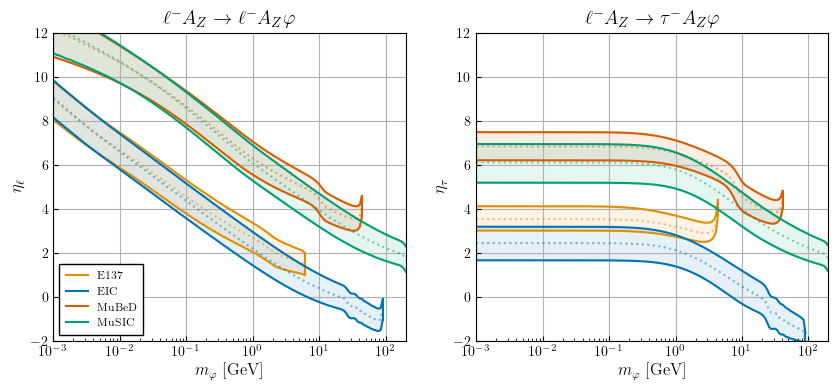

In [94]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

plot_distribution_average('E137', ('e', 'scalar', 1.0, 'exact', False), which = 'eta', final_state_particle = 'lepton')
plot_distribution_average('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False), which = 'eta', final_state_particle = 'lepton')
plot_distribution_average('MuCol', ('mu', 'scalar', 1.0, 'exact', False), which = 'eta', final_state_particle = 'lepton')
plot_distribution_average('MuSIC', ('mu', 'scalar', 1.0, 'exact', False), which = 'eta', final_state_particle = 'lepton')

#ax1.text(2.1, 10.4, '$\\theta = m_\\ell / E_\\ell$', color = 'black')
#ax1.annotate('', (40, 9.8), (22, 10.65),
#             arrowprops = dict(arrowstyle = '->', color = 'black'))
#ax1.annotate('', (40, 11.3), (22, 10.52),
#             arrowprops = dict(arrowstyle = '->', color = 'black'))

#ax1.axhline(-np.log(np.tan(5.11e-4/(2*20))), color = 'black', linestyle = 'dashed')
#ax1.axhline(-np.log(np.tan(0.106/(2*1000))), color = 'black', linestyle = 'dashed')

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.plot([100], color = colors[3], label = '${\\rm MuBeD}$')
ax1.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'lower left',
           fontsize = 8,
           borderpad = 0.6)

ax1.set_title('$\\ell^- A_Z \\rightarrow \\ell^- A_Z \\varphi$', fontsize = 14)
ax1.set_ylabel('$\\eta_\\ell$', fontsize = 12)
ax1.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax1.tick_params(which = 'both', direction = 'in')
ax1.grid()
ax1.set_xscale('log')
ax1.set_xlim(1e-3, 2e2)
ax1.set_ylim(-2, 12)

ax2 = fig.add_subplot(gs[1])

plot_distribution_average('E137', ('tau', 'scalar', 1.0, 'exact', False), which = 'eta', final_state_particle = 'lepton')
plot_distribution_average('EIC_Gold', ('tau', 'scalar', 1.0, 'exact', False), which = 'eta', final_state_particle = 'lepton')
plot_distribution_average('MuCol', ('tau', 'scalar', 1.0, 'exact', False), which = 'eta', final_state_particle = 'lepton')
plot_distribution_average('MuSIC', ('tau', 'scalar', 1.0, 'exact', False), which = 'eta', final_state_particle = 'lepton')


#ax2.text(2.1e-3, 5, '$\\theta = m_\\tau / E_\\ell$', color = 'black')
#ax2.annotate('', (4e-2, 3.1), (2.4e-2, 5.27),
#             arrowprops = dict(arrowstyle = '->', color = 'black'))
#ax2.annotate('', (4e-2, 7), (2.4e-2, 5.10),
#             arrowprops = dict(arrowstyle = '->', color = 'black'))


#ax2.axhline(-np.log(np.tan(1.77/(2*20))), color = 'black', linestyle = 'dashed')
#ax2.axhline(-np.log(np.tan(1.77/(2*1000))), color = 'black', linestyle = 'dashed')

ax2.set_title('$\\ell^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax2.set_ylabel('$\\eta_\\tau$', fontsize = 12)
ax2.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax2.tick_params(which = 'both', direction = 'in')
ax2.grid()
ax2.set_xscale('log')

ax2.set_xlim(1e-3, 2e2)
ax2.set_ylim(-2, 12)

/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_40074/1273969183.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  y_tot = np.trapz(ys, x = xs).reshape(-1, 1)
/var/folders/9j/5j3ms12n47l37zn7gdtssx0w0000gn/T/ipykernel_40074/1273969183.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  y_ints = np.array([np.trapz(ys[:, :idx]/y_tot, x = xs[:, :idx]) for idx in range(len(xs[0]))]).T


(1.0, 10000.0)

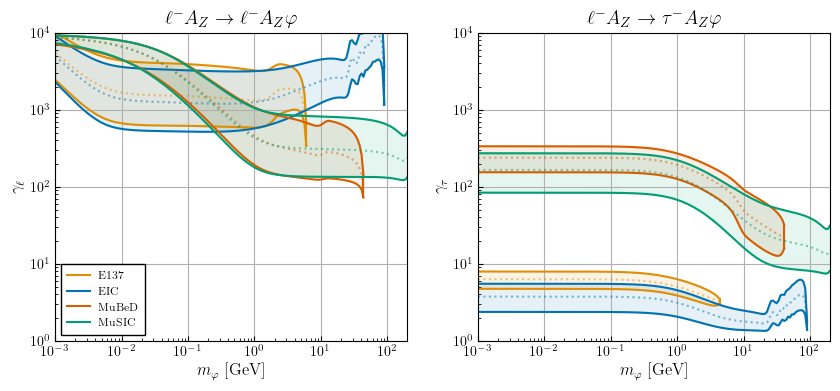

In [95]:
fig = plt.figure(figsize = (10, 4))

gs = GridSpec(1, 2, wspace = 0.2)

ax1 = fig.add_subplot(gs[0])

plot_distribution_average('E137', ('e', 'scalar', 1.0, 'exact', False), which = 'gamma', final_state_particle = 'lepton')
plot_distribution_average('EIC_Gold', ('e', 'scalar', 1.0, 'exact', False), which = 'gamma', final_state_particle = 'lepton')
plot_distribution_average('MuCol', ('mu', 'scalar', 1.0, 'exact', False), which = 'gamma', final_state_particle = 'lepton')
plot_distribution_average('MuSIC', ('mu', 'scalar', 1.0, 'exact', False), which = 'gamma', final_state_particle = 'lepton')

#ax1.text(2.1, 20, '$\\gamma = E_\\ell / m_\\ell$', color = 'black')
#ax1.annotate('$\\gamma = E_\\ell / m_\\varphi$', (10, 2.1), (2.1, 15),
#             arrowprops = dict(arrowstyle = '->', color = 'black'))
#ax1.annotate('', (10, 100), (7, 25),
#             arrowprops = dict(arrowstyle = '->', color = 'black'))

masses = np.array(process_run_card('E137.txt', 'masses'))

ax1.plot([100], color = colors[1], label = '${\\rm E137}$')
ax1.plot([100], color = colors[0], label = '${\\rm EIC}$')
ax1.plot([100], color = colors[3], label = '${\\rm MuBeD}$')
ax1.plot([100], color = colors[2], label = '${\\rm MuSIC}$')
ax1.legend(fancybox = False,
           facecolor = 'white',
           edgecolor = 'black',
           framealpha = 1,
           loc = 'lower left',
           fontsize = 8,
           borderpad = 0.6)

ax1.set_title('$\\ell^- A_Z \\rightarrow \\ell^- A_Z \\varphi$', fontsize = 14)
ax1.set_ylabel('$\\gamma_\\ell$', fontsize = 12)
ax1.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax1.tick_params(which = 'both', direction = 'in')
ax1.grid()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-3, 2e2)
ax1.set_ylim(1e0, 1e4)

ax2 = fig.add_subplot(gs[1])

plot_distribution_average('E137', ('tau', 'scalar', 1.0, 'exact', False), which = 'gamma', final_state_particle = 'lepton')
plot_distribution_average('EIC_Gold', ('tau', 'scalar', 1.0, 'exact', False), which = 'gamma', final_state_particle = 'lepton')
plot_distribution_average('MuCol', ('tau', 'scalar', 1.0, 'exact', False), which = 'gamma', final_state_particle = 'lepton')
plot_distribution_average('MuSIC', ('tau', 'scalar', 1.0, 'exact', False), which = 'gamma', final_state_particle = 'lepton')


#ax2.annotate('$\\gamma = E_\\ell / m_\\varphi$', (10, 2.1), (2.1, 15),
#             arrowprops = dict(arrowstyle = '->', color = 'black'))
#ax2.annotate('', (10, 100), (7, 25),
#             arrowprops = dict(arrowstyle = '->', color = 'black'))

#ax2.plot(masses, 20/masses, color = 'black', linestyle = 'dashed')
#ax2.plot(masses, 1000/masses, color = 'black', linestyle = 'dashed')

ax2.set_title('$\\ell^- A_Z \\rightarrow \\tau^- A_Z \\varphi$', fontsize = 14)
ax2.set_ylabel('$\\gamma_\\tau$', fontsize = 12)
ax2.set_xlabel('$m_\\varphi~[{\\rm GeV}]$', fontsize = 12)

ax2.tick_params(which = 'both', direction = 'in')
ax2.grid()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1e-3, 2e2)
ax2.set_ylim(1e0, 1e4)